# Generate Blunders   
---
Python notebook to generate data we can then pass into a stronger model to give us explanation traces for why a move is a bad move (due to a blunder / etc.).

Use Stockfish to rollout the expected outcome to the point where a move becomes a 'bad move' then pass this all into a prompt.

In [1]:
import os, sys, asyncio
import random, json
import numpy as np
import pandas as pd
from typing import List, Tuple
from IPython.display import SVG, display
from pathlib import Path

import chess
import chess.svg
import chess.engine

if sys.platform == "win32":
    asyncio.set_event_loop_policy(asyncio.WindowsProactorEventLoopPolicy())

from board import convert_board

In [14]:
class SingleMoveTrace:
    """
    Generate a short, English-language trace for **one** move.

    Modes
    -----
    • mode='best'   – choose the engine’s top move and play perfect chess
                      for up to *max_plies* plies (default 4).  
                      The move is kept **only if**

                          final_eval − start_eval ≥ GOOD_CP  ( +100 cp )

                      where *final_eval* is the evaluation after the entire
                      line of perfect replies, *start_eval* is the score of
                      the root position.

    • mode='worst'  – sample a blunder whose *final* evaluation after perfect
                      replies differs from the start position by ≥ SWING_CP
                      (200 cp).

    Constructor parameters
    ----------------------
    mode       : {'best','worst'}, default 'worst'
    temp       : float,  default 2.5   (sampling temperature for blunders)
    max_plies  : int,    default 4     (number of plies to show, inclusive)
    depth      : int,    default 10    (search depth for every engine call)
    multipv    : int,    default 40    (lines requested when picking a move)

    Returns
    -------
    ([str, …], chess.Move) – narration lines (first line is an intro) and the
    chosen move.
    """

    STOCKFISH_PATH = (
        "../programmatic_explanations/stockfish/stockfish-windows-x86-64-avx2.exe"
    )

    SWING_CP = 200      # threshold for a “big blunder” (centipawns)
    GOOD_CP  = 50       # required gain for a “good” move   (centipawns)
    MATE_CP  = 10_000   # centipawn equivalent used for mate scores

    PIECE = {
        chess.PAWN:   "pawn",
        chess.KNIGHT: "knight",
        chess.BISHOP: "bishop",
        chess.ROOK:   "rook",
        chess.QUEEN:  "queen",
        chess.KING:   "king",
    }

    # --------------------------- init -------------------------------
    def __init__(
        self,
        mode: str = "worst",
        *,
        temp: float = 2.5,
        max_plies: int = 4,
        depth: int = 10,
        multipv: int = 40,
    ) -> None:
        if mode not in {"best", "worst"}:
            raise ValueError("mode must be 'best' or 'worst'")

        self.mode      = mode
        self.temp      = temp
        self.max_plies = max_plies
        self.depth     = depth
        self.multipv   = multipv

        self.engine = chess.engine.SimpleEngine.popen_uci(self.STOCKFISH_PATH)

    # ------------------------ life-cycle ----------------------------
    def close(self) -> None:
        self.engine.quit()

    # ========================== PUBLIC ==============================
    def analyze(self, fen: str) -> tuple[list[str], chess.Move]:
        board     = chess.Board(fen)
        root_side = board.turn

        root_infos = self._analyse(board, multipv=self.multipv)
        # sort worst→best for the mover
        root_infos.sort(key=lambda inf: self._cp(inf["score"].pov(root_side)))

        if self.mode == "best":
            return self._best_line(board, root_infos, root_side)
        return self._worst_line(board, root_infos, root_side)

    # ===================== BEST-MOVE HANDLING =======================
    def _best_line(
        self,
        board: chess.Board,
        root_infos: list[chess.engine.InfoDict],
        root_side: chess.Color,
    ) -> tuple[list[str], chess.Move]:
        best_info = root_infos[-1]               # engine’s top suggestion
        best_move = best_info["pv"][0]

        start_cp = self._cp(best_info["score"].pov(root_side))

        # Roll out best play for ≤ max_plies plies
        moves, final_cp = self._rollout(board, best_move, root_side)

        gain = final_cp - start_cp
        if gain < self.GOOD_CP:
            raise ValueError(
                f"Best move improves by only {gain:+.0f} cp "
                f"(< +{self.GOOD_CP})."
            )

        intro = (
            f"Playing {chess.square_name(best_move.from_square)}"
            f"{chess.square_name(best_move.to_square)} improves the position "
            f"by {gain:+.0f} cp.  The following line might ensue:"
        )
        narr = self._dictate(board, moves, root_side)
        return [intro] + [f"{i}) {s}" for i, s in enumerate(narr, 1)], best_move

    # ===================== WORST-MOVE HANDLING ======================
    def _worst_line(
        self,
        board: chess.Board,
        root_infos: list[chess.engine.InfoDict],
        root_side: chess.Color,
    ) -> tuple[list[str], chess.Move]:
        start_cp = self._cp(root_infos[-1]["score"].pov(root_side))

        cps    = np.array([self._cp(inf["score"].pov(root_side)) for inf in root_infos])
        logits = -(cps - cps.max()) / (100 * self.temp)
        probs  = self._safe_softmax(logits)

        for idx in np.random.choice(len(root_infos), len(root_infos), False, probs):
            info    = root_infos[idx]
            blunder = info["pv"][0]
            delta0  = self._cp(info["score"].pov(root_side)) - start_cp

            moves, final_cp = self._rollout(board, blunder, root_side)

            if abs(final_cp - start_cp) < self.SWING_CP:
                continue

            intro = (
                f"Playing {chess.square_name(blunder.from_square)}"
                f"{chess.square_name(blunder.to_square)} blunders {delta0:+.0f} cp.  "
                "The following line would likely play out:"
            )
            narr = self._dictate(board, moves, root_side)
            return [intro] + [f"{i}) {s}" for i, s in enumerate(narr, 1)], blunder

        raise ValueError("No move within MULTIPV produced a ≥ 200 cp swing.")

    # ================= ENGINE & SMALL HELPERS ======================
    def _analyse(self, board: chess.Board, *, multipv: int = 1):
        return self.engine.analyse(
            board, chess.engine.Limit(depth=self.depth), multipv=multipv
        )

    def _cp(self, score: chess.engine.Score) -> int:
        if score.is_mate():
            return self.MATE_CP if score.mate() > 0 else -self.MATE_CP
        return score.score(mate_score=self.MATE_CP) or 0

    @staticmethod
    def _safe_softmax(x: np.ndarray) -> np.ndarray:
        x -= x.max()
        exp_x = np.exp(x)
        s = exp_x.sum()
        if s == 0 or np.isnan(s):
            return np.full_like(x, 1 / len(x), dtype=float)
        return exp_x / s

    # --------------------------- rollout ----------------------------
    def _rollout(
        self,
        board: chess.Board,
        first_move: chess.Move,
        root_side: chess.Color,
    ) -> tuple[list[chess.Move], int]:
        """
        Execute `first_move`, then alternate perfect replies until either:
        • trace reaches `self.max_plies` plies, or
        • the game ends.

        Returns (moves, final_eval_cp)  where *final_eval_cp* is from
        root_side’s point of view.
        """
        start_cp = self._cp(self._analyse(board)[0]["score"].pov(root_side))

        moves = [first_move]
        board.push(first_move)

        while len(moves) < self.max_plies:
            info = self._analyse(board)[0]
            if info.get("pv") is None:
                break           # game ended (mate / stalemate)
            best_reply = info["pv"][0]
            moves.append(best_reply)
            board.push(best_reply)

            if len(moves) >= self.max_plies:
                break

        final_cp = self._cp(self._analyse(board)[0]["score"].pov(root_side))

        # restore caller’s board
        while board.move_stack:
            board.pop()

        return moves, final_cp

    # -------------------------- narration ---------------------------
    def _dictate(
        self,
        start_board: chess.Board,
        moves: list[chess.Move],
        root_side: chess.Color,
    ) -> list[str]:
        lines, board = [], start_board.copy()
        for mv in moves:
            you_move  = board.turn == root_side
            mover_col = "black" if board.turn == chess.BLACK else "white"
            piece     = self.PIECE[board.piece_type_at(mv.from_square)]
            frm       = chess.square_name(mv.from_square)
            to        = chess.square_name(mv.to_square)

            if board.is_capture(mv):
                victim = (
                    board.piece_at(mv.to_square)
                    if not board.is_en_passant(mv)
                    else board.piece_at(
                        chess.square(chess.square_file(mv.to_square),
                                     chess.square_rank(mv.from_square))
                    )
                )
                victim_piece = self.PIECE[victim.piece_type]
                actor_own  = "Your" if you_move else "Opponent’s"
                victim_own = "opponent’s" if you_move else "your"
                line = (
                    f"{actor_own} {mover_col} {piece} at {frm} "
                    f"captures {victim_own} {victim_piece} at {to}"
                )
            else:
                if you_move:
                    line  = f"You move the {mover_col} {piece} from {frm} to {to}"
                else:
                    line  = f"Opponent moves the {mover_col} {piece} from {frm} to {to}"
                    
            lines.append(line)
            board.push(mv)

        return lines

### Visualize and test our samples

In [15]:
df = pd.read_csv('deepmind_data/train_20k.csv')   # Import prog_data/train_20k.csv instead
bad_sampler = SingleMoveTrace(
    mode = 'worst',
    temp = 5.0,
    max_plies = 4,
    depth = 10,
    multipv = 40
)
best_sampler = SingleMoveTrace(
    mode = 'best', 
    temp = 0.2,
    max_plies = 5,
    depth = 15,
    multipv = 1
)

2kr3r/1b3ppp/p4n2/2bP2B1/2p5/2N2N2/1P3PPP/R2R1K2 b - - 5 17


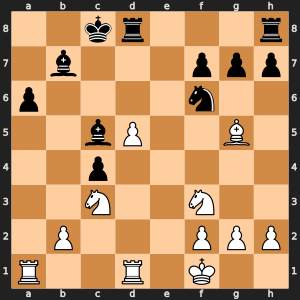

Good move trace failure: Best move improves by only +16 cp (< +50).
Bad Move Trace:
Playing c5d4 blunders -435 cp.  The following line would likely play out:
1) You move the black bishop from c5 to d4
2) Opponent’s white rook at d1 captures your bishop at d4
3) Your black knight at f6 captures opponent’s pawn at d5
4) Opponent’s white knight at c3 captures your knight at d5
c5d4


Good Move Trace:


In [16]:
# Optionally can test various parts of the generation
df = df.sample(frac=1).reset_index(drop=True)
fen = df.iloc[0]['FEN']
board = chess.Board(fen)
print(fen)

display(SVG(chess.svg.board(board=board, size=300)))

# Analyze postion
try:
    bad_move_trace, blunder_move = bad_sampler.analyze(fen)
except Exception as e:
    bad_move_trace, blunder_move = None, None
    print(f"Bad move trace failure: {e}")

try:
    good_move_trace, best_move = best_sampler.analyze(fen)
except Exception as e:
    good_move_trace, best_move = None, None
    print(f"Good move trace failure: {e}")

# Print each one
print("Bad Move Trace:\n===========================================")
if bad_move_trace:
    for move in bad_move_trace:
        print(move)
    print(f"{blunder_move}\n\n")

print("Good Move Trace:\n===========================================")
if good_move_trace:
    for move in good_move_trace:
        print(move)
    print(best_move)

In [ ]:
def generate_trace_dataset(
    sampler,                      # pre-configured SingleMoveTrace instance
    df,                           # pandas DataFrame with a “FEN” column
    convert_board,                # fn(fen, notation) -> str
    *,
    num_samples: int = 1250,
    board_notation: str = "visual",
    out_dir: str = "processed_data",
) -> list[dict]:
    """
    Build a JSONL dataset of “good-move” *or* “blunder” explanations, depending
    on `sampler.mode` ('best' or 'worst').

    Returns the in-memory list as well.
    """
    label       = "goodmove" if sampler.mode == "best" else "blunder"
    sys_prompt  = f"{label}_syntheticgenerator_sysprompt.txt"
    out_path    = Path(out_dir)
    out_path.mkdir(exist_ok=True)
    outfile     = out_path / f"{label}_explanations_{num_samples}.jsonl"

    dataset, ok, errs = [], 0, 0
    print(f"Generating {num_samples} {label} samples…")

    while ok < num_samples:
        try:
            fen = df.sample(1)["FEN"].iat[0]
            trace, mv = sampler.analyze(fen)

            prompt = (
                f"Below is a board in a game you're currently playing.\n\n"
                f"{convert_board(fen, board_notation)}\n\n"
                f"The following explains a line that would be considered a "
                f"{label.replace('_', ' ')}.\n\n"
                f"{' '.join(trace)}\n\n"
                "Remember — wrap your final explanation in <answer> tags and "
                "think out loud first."
            )

            dataset.append(
                {
                    "chat": [
                        ["system", sys_prompt],
                        ["user", prompt],
                        ["assistant", ""],
                    ],
                    "info": {
                        "board": fen,
                        f"move": chess.square_name(mv.from_square)
                                       + chess.square_name(mv.to_square),
                    },
                }
            )
            ok += 1
            if ok % 100 == 0:
                print(f"{ok}/{num_samples}")

        except ValueError:          # sampler found no qualifying move
            errs += 1
        except Exception as e:
            print("Unexpected:", e)

    with open(outfile, "w") as fh:
        for s in dataset:
            fh.write(json.dumps(s) + "\n")

    print(f"Saved to {outfile}  |  success {ok}  |  ValueErrors {errs}")
    return dataset

In [20]:
# Blunder dataset
blunder_ds = generate_trace_dataset(bad_sampler, df, convert_board, num_samples=1000)

# Good move dataset
good_ds = generate_trace_dataset(best_sampler, df, convert_board, num_samples=300)

Generating 1000 blunder samples…
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Saved to processed_data\blunder_explanations_1000.jsonl  |  success 1000  |  ValueErrors 76
Generating 300 good_move samples…
100/300
200/300
300/300
Saved to processed_data\good_move_explanations_300.jsonl  |  success 300  |  ValueErrors 2248


## Process our Data   
---


In [3]:
import ast
import re
import json
from pathlib import Path
from board import convert_board

def extract_answer_tags(text):
    """Extract content between <answer> </answer> tags"""
    pattern = r'<answer>\s*(.*?)\s*</answer>'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        raise ValueError("No <answer> tags found in model response")

def process_model_outputs(json_file_path, output_filename):
    """Process the model outputs JSON file and save processed data to JSONL"""
    
    # Load the JSON file
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Use ast.literal_eval if the data is stored as string
    if isinstance(data, str):
        data = ast.literal_eval(data)
    
    processed_samples = []
    errors = 0
    
    for sample in data:
        try:
            # Extract model_response and info
            model_response = sample['model_response']
            info = sample['info']
            
            # Extract content between answer tags
            parsed_model_response = extract_answer_tags(model_response)
            
            # Get blunder move and board from info
            proposed_move = info['move']
            board_fen = info['board']
            
            # Convert board using the convert_board function
            user_prompt = f"""Below is a board in a game I'm currently playing.

{convert_board(board_fen, "visual")}

I'm thinking about playing {proposed_move}. Do you think I should play this move?"""
            
            # Create processed sample
            processed_data = dict()
            processed_data['chat'] = [
                ["system", "syntheticmove_generation_sysprompt.txt"],
                ["user", user_prompt],
                ["assistant", parsed_model_response]
            ]
            
            processed_samples.append(processed_data)
            
        except Exception as e:
            errors += 1
            continue
    
    # Save to processed_data folder as JSONL
    processed_data_dir = Path("processed_data")    
    output_path = processed_data_dir / output_filename
    with open(output_path, 'w', encoding='utf-8') as f:
        for sample in processed_samples:
            f.write(json.dumps(sample) + '\n')
    
    print(f"Successfully processed {len(processed_samples)} samples")
    print(f"Errors encountered: {errors}")
    print(f"Data saved to: {output_path}")
    
    return processed_samples

# Process the data and save to JSONL
json_file_path = 'model_outputs/blunder_explanations_1000_all_20250626-060214.json'
output_filename = 'syntheticmoves_blunders_1000.jsonl'
processed_data = process_model_outputs(json_file_path, output_filename)

Successfully processed 1000 samples
Errors encountered: 0
Data saved to: processed_data\syntheticmoves_blunders_1000.jsonl
